# Signal identification and spectral moments in spectral-cube #

## Authors ##
[Eric Koch](https://github.com/e-koch), [Adam Ginsburg](https://github.com/keflavich), [Tom Robitaille](https://github.com/astrofrog), [Erik Rosolowsky](https://github.com/low-sky)

## Summary ##

This tutorial demonstrates how to identify signal in spectral-line data cubes, mask out noise, and calculate common spectral moments (integrated intensity, centroid velocity, line widths, peak intensity, and velocity at peak intensity).
These examples will use brightness temperature as the brightness unit and velocity as the spectral unit (in the radio convention), but equivalent brightness units (e.g., Jy/beam) and spectral units (frequency, wavelength) can also be used.

## Learning goals ##

* Noise calculation and identifying signal
* Creating and applying signal masks
* Calculating moment maps from the masked cube

## Keywords ##

radio astronomy, spectral-line data cubes, signal identification, moments

## Requires ##

```
pip install astropy
pip install spectral-cube
pip install radio-beam
pip install dask
pip install dask-image
pip install aplpy
```


In [2]:
%matplotlib inline

import os
from pathlib import Path
from time import time
import warnings

import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-colorblind')

import astropy.units as u
from astropy.io import fits

from spectral_cube import SpectralCube

# Uncomment to create a progress bar for all dask operations.
# Disabled here as it increases the run time significantly for this small cube.
# from dask.diagnostics import ProgressBar
# pbar = ProgressBar()
# pbar.register()

For this tutorial, we will download a small region of M33 tracing the CO(2-1) molecular line transition. This is a region taken from a larger ALMA mosaic observed with the ACA (Morita) 7-m array (Project ID: 2019.1.01182.S).

In [3]:
from astropy.utils.data import download_file

filename = download_file(
    'https://zenodo.org/record/4050489/files/M33_ALMA_ACA_12CO21.cutout.fits',
    cache=True, show_progress=True)

# Note that the datafile will not end in ".fits". Because of that, we need to specify the format
# When the file name end in "fits", `format` will not need to be specified 
cube = SpectralCube.read(filename, format='fits', use_dask=True)

# Convert to km/s for the spectral unit
cube = cube.with_spectral_unit(u.km / u.s)

First, we will look at a summary of this spectral-cube:

In [4]:
cube

DaskSpectralCube with shape=(300, 64, 64) and unit=K and chunk size (300, 64, 64):
 n_x:     64  type_x: RA---SIN  unit_x: deg    range:    23.408277 deg:   23.428647 deg
 n_y:     64  type_y: DEC--SIN  unit_y: deg    range:    30.750561 deg:   30.768065 deg
 n_s:    300  type_s: VRAD      unit_s: km / s  range:     -280.000 km / s:     -79.670 km / s

This provides most of the basical details about the cube, including the brightness unit (K), the pixel shape (`(300, 64, 64)`) and the spatial and spectral extent of the cube.

**Note:** DaskSpectralCube loads in chunks of the data at once to enable parallel processing while avoiding large memory usage by reading in the whole cube into memory. This example uses a small cube and so the entire cube fits inside 1 chunk.

## Signal identification and noise estimation ##

To calculate basic properties of the signal in the cube, we first need to identify the noise properties and (ideally) remove its effect on the properties of the signal.

In many cases, you will likely know approximately what the noise level is based on the integration time used to create the image. In this example, we expect a noise level of $\sim80$ mK per $0.67$ km s$^{-1}$ spectral channel, however, the image is a mosaic of pointings and small variations in the integration time per pointing will cause the noise to spatially vary across the map. Similarly, the edges of the mosaic (i.e., the edge of the telescope's view) will also have a higher noise level. In this example, we will look for spatial or spectral noise variations and compare our noise expectation of $80$ mK to these estimates.

Some properties, like the peak intensity, are not severely affected by noise where the signal-to-noise ratio is high. We can use the peak intensity to roughly visualize where the signal is located:

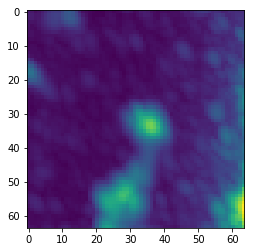

In [5]:
peak_intensity = cube.max(axis=0) # Take the maximum along the spectral dimension

# Quick vizualization
peak_intensity.quicklook()

We see that there is likely signal near the centre of the cube extending up to the Northern edge. However, we also see what appears to be brighter emission towards the north-west edge (note that the x-axis is East to West following astronomical convention). We want to distinguish whether this is real emission, or if the noise is higher towards that part of the map.



Estimating the noise can be difficult if it varies both spatially and spectrally in the cube but is easier if we can assume it is roughly uniform in at least one dimension.

In this case, we suspect the noise may spatially vary, based on the image above. We next want to estimate if the noise _spectrally_ varies. To do this, we will calculate the standard deviation from the [median absolute deviation](https://docs.astropy.org/en/stable/api/astropy.stats.mad_std.html#astropy.stats.mad_std) in astropy, which is a robust estimator that is less sensitive to large outliers:

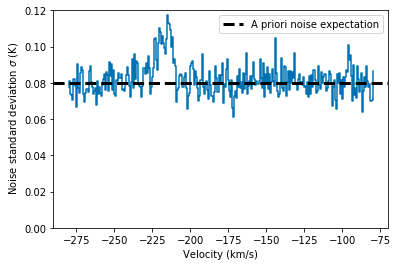

In [6]:
mad_std_spectrum = cube.mad_std(axis=(1, 2))

plt.plot(mad_std_spectrum.spectral_axis.value, mad_std_spectrum.value, drawstyle='steps-mid')
plt.xlabel('Velocity (km/s)')
plt.ylabel(r' Noise standard deviation $\sigma$ (K)')

# Best to extend the range to 0.
plt.ylim([0., 0.12])

plt.axhline(0.08, linestyle='--', color='k', linewidth=3, label='A priori noise expectation')
plt.legend(frameon=True)

The noise is mostly uniform, apart from a narrow range of channels. However, we calculated this spectral using _all_ of the data, including the actual signal. Outside of this range, the typical noise level is $\sim0.08$ K, or $80$ mK, per spectral channel.

To test if the signal is causing an apparently larger "noise" level, we can use [sigma clipping](https://docs.astropy.org/en/stable/stats/robust.html#sigma-clipping) to iteratively remove the signal in those channels. Sigma clipping recalculates the noise standard deviation and remove large outliers beyond some threshold number of sigma, and iterates until the noise standard deviation value converges.

In spectral-cube, sigma clipping along the spectral dimension is available with the [SpectralCube.sigma_clip_spectrally](https://spectral-cube.readthedocs.io/en/latest/api/spectral_cube.spectral_cube.SpectralCube.html#spectral_cube.spectral_cube.SpectralCube.sigma_clip_spectrally) function:

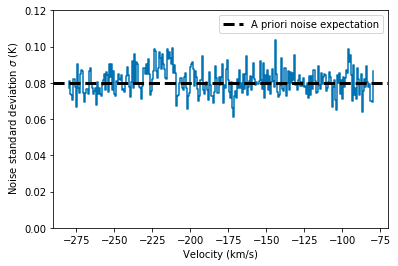

In [7]:
cube_sclip = cube.sigma_clip_spectrally(3) # Clip values above 3-sigma

mad_std_spectrum_sclip = cube_sclip.mad_std(axis=(1, 2))

plt.plot(mad_std_spectrum_sclip.spectral_axis.value, mad_std_spectrum_sclip.value, drawstyle='steps-mid')
plt.xlabel('Velocity (km/s)')
plt.ylabel(r' Noise standard deviation $\sigma$ (K)')

# Best to extend the range to 0.
plt.ylim([0., 0.12])

plt.axhline(0.08, linestyle='--', color='k', linewidth=3, label='A priori noise expectation')
plt.legend(frameon=True)

After sigma-clipping, the apparent spike has largely gone away, indicating that it was due to actualy signal, not an increase in the noise level.

**Exercise:** An important note with sigma clipping is that choosing too low of a threshold will cause erroneously low noise estimates. To demonstrate this, run the above cell after lowering the threshold at $<3\sigma$. What happens to the noise standard deviation in all spectral channels?

The above shows that we can treat the noise level as approximately constant in the spectral dimension. Because of this, we can estimate the noise level for each spatial pixel from its spectrum. Instead of calculating the noise standard deviation spectrum, we will calculate its _spatial map_ using the sigma clipped cube from above.

**Note:** If you lowered the $\sigma$ threshold from above, be sure to restore the thresold to $\sim3\sigma$ before continuing on.

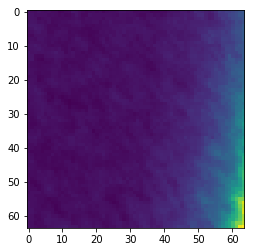

In [8]:
mad_std_map_sclip = cube_sclip.mad_std(axis=0) # Calculate sigma along the spectral dimension

mad_std_map_sclip.quicklook()

This spatial map gives us a lot of information on where signal is located versus where the noise level is higher. Compared to the peak intensity map we started with, we see that the apparent bright emission in the North-east corner has $\sim5\times$ the noise level as in the centre.

** What if the noise in my cube varies spatially _and_ spectrally? **

This is a much harder case to deal with for two reasons: (1) it is more computationally expensive because we cannot create a noise spectrum or map like we have above; (2) we have less data to compute the noise level for each pixel. To best estimate the noise, we would need to calculate an entire noise _cube_. Further, we would need to make some simplifying assumptions. For example, to have enough data to estimate the noise in each pixel, we would need to identify a neighbourhood around that pixel over a few resolution elements, which assumes that the noise varies smoothly in the cube.

This case is beyond the current tutorial. An example of this calculation, however, is available in the [PHANGS imaging pipeline](https://github.com/akleroy/phangs_imaging_scripts/blob/master/phangsPipeline/scNoiseRoutines.py#L91) (see [Leroy+2021](https://ui.adsabs.harvard.edu/abs/2021arXiv210407665L/abstract)).

The above spatial map is our _noise model_ for the cube. Now, we will use it separate signal from noise in the cube.

In this example, we will use one of the most common signal identification techniques outlined in [Rosolowsky & Leroy (2006)](https://ui.adsabs.harvard.edu/abs/2006PASP..118..590R/abstract) (amongst others).

This technique defines two initial masks:

1. A low signal mask that includes more signal but is affected by spurious noise. Here we use $>3\sigma$.
2. A high signal mask that includes less signal but is not less affected by noise. Here we use $>6\sigma$.

The goal is to identify connected regions in the low signal mask that are also in the high signal mask, and remove those that are only in the low signal mask that are likely just noise.


In [9]:
# Make a low and high mask
low_snr_mask = (cube > 3 * mad_std_map_sclip).include()
high_snr_mask = (cube > 6 * mad_std_map_sclip).include()

# If using scipy.ndimage, UNCOMMENT BELOW.
# W need to convert from a dask array to a numpy array.
# This can be done by "computing" the mask (see text below for more details)

# low_snr_mask = low_snr_mask.compute()
# high_snr_mask = high_snr_mask.compute()

Here we have defined an "inclusion" mask, meaning `True` in the mask are pixels we are interested in operating on. With spectral-cube's masks, the inclusion mask is returned as an array using `.include()`.

Next, we will label connected regions in `low_snr_mask` and label them. `low_snr_mask` and `high_snr_mask` are both dask arrays. We define regions as connected as 27-connected, meaning all edge and corner connections are included in 3D. The equivalent in 2D is 8-connected and would have a structure element like:

```
[1, 1, 1]
[1, 1, 1]
[1, 1, 1]
```

In this example, we will use the [dask-image.ndmeasure](http://image.dask.org/en/latest/) package that provides morphological operations equivalent to [scipy.ndimage](https://docs.scipy.org/doc/scipy/reference/ndimage.html) for numpy arrays. dask-image is better for huge files that will not fit into memory. If you are using small data cubes, the standard scipy routines may be faster.

*** Dask arrays -- what is `compute`? ***

When using the `dask_image` masking code below, you will see places with an extra `compute()` call. Operations on dask arrays are delayed, meaning dask only figures out _how_ to do the computation when the function is called. The operation is only actually computed when we call `compute`. A simple example is shown in the [dask documentation](https://docs.dask.org/en/latest/api.html#dask.compute).

In the code below, we need to call `compute` to find the number of labels as this requires dask complete the operation.


In [10]:
from dask_image import ndmeasure

# Find connected structures
structure = np.ones((3, 3, 3), dtype=bool)

low_snr_mask_labels, num_labels = ndmeasure.label(low_snr_mask,
                                                  structure=structure)

# Ask dask to execute the operation
num_labels = num_labels.compute()


# With scipy.ndimage:
# import scipy.ndimage as nd

# structure = np.ones((3, 3, 3), dtype=bool)

# low_snr_mask_labels, num_labels = nd.label(low_snr_mask,
#                                            structure=structure)

print(f"Initial number of regions found: {num_labels}")



Initial number of regions found: 360


*** Mask labels and indexing ***

In `low_snr_mask_labels`, regions outside the mask have a value of `0`. This means that the first label starts at `1` and continues up to the number of labeled regions (in this case, `360`). However, python indexing starts at `0`. When looping through the regions, we need to account for this `+1` difference, and so in the code below, you will see ranges and loops with a +1 offset applied (e.g., `range(1, num_labels + 1)`).

Many regions are initially included in the mask, but we only expect a few real regions of signal based on the peak intensity map from above.

Most of the regions are small, spurious regions due to noise. To remove these, we will apply 2 criteria:

1. All regions in `low_snr_mask` must contain $>5$ pixels above $6\sigma$ (the `high_snr_mask`). To do this, we calculate the sum of `high_snr_mask` within the `low_snr_mask_labels`.
2. Regions in `low_snr_mask` must contain $>40$ pixels. Similarly, we calculate the sum of `low_snr_mask` within the `low_snr_mask_labels`.

Regions that do not satisfy these criteria are removed from the mask.

The exact number of pixels for each criteria are approximate only and determined by checking different thresholds. A good rule-of-thumb is for regions in `low_snr_mask` to be greater than the number of pixels in the beam. $40$ pixels is approximately the number of pixels within the FWHM of the beam for these data, and so is the minimum number we expect for real signal within 1 spectral channel.

In [11]:
# From the labels, count the number of pixels within each label.

# Count how many >6 sigma pixels (high_snr_mask) are within regions defined in low_snr_mask_labels
num_pixels_in_high_snr_mask = ndmeasure.sum_labels(high_snr_mask,
                                                   label_image=low_snr_mask_labels,
                                                   index=range(1, num_labels + 1)) # +1 offset for mask labels

# Count how many >3 sigma pixels (low_snr_mask) are within regions defined in low_snr_mask_labels.
num_pixels_in_low_snr_mask = ndmeasure.sum_labels(low_snr_mask,
                                                  label_image=low_snr_mask_labels,
                                                  index=range(1, num_labels + 1)) # +1 offset for mask labels

# With scipy.ndimage:
# import scipy.ndimage as nd

# num_pixels_in_high_snr_mask = nd.sum(high_snr_mask,
#                                      labels=high_snr_mask_labels,
#                                      index=range(1, num_labels + 1)) # +1 offset for mask labels

# # Repeat for the high signal mask.
# num_pixels_in_low_snr_mask = nd.sum(low_snr_mask,
#                                     labels=low_snr_mask_labels,
#                                     index=range(1, num_labels + 1)) # +1 offset for mask labels

# To preserve the low_snr_mask, we will create a new signal mask where we will remove 
# regions that do not pass the criteria.
signal_mask = low_snr_mask

low_min_pixels = 40
high_min_pixels = 5

for num, (high_pix_num, low_pix_num) in enumerate(zip(num_pixels_in_high_snr_mask, num_pixels_in_low_snr_mask)):
    if high_pix_num >= high_min_pixels and low_pix_num >= low_min_pixels:
        # This region passes the criteria. Keep it in the mask.
        continue

    # Remove regions that do not pass the criteria.
    # NOTE: enumerate will start with 0, but the mask labels start at 1
    # We apply a +1 offset to `num` to account for this.
    signal_mask[low_snr_mask_labels == num + 1] = False


To find the final number of regions containing real signal, we will label the final `signal_mask`.

In [12]:
signal_mask_labels, num_labels = ndmeasure.label(signal_mask,
                                                  structure=structure)

num_labels = num_labels.compute()

# With scipy.ndimage:
# import scipy.ndimage
# signal_mask_labels, num_labels = nd.label(signal_mask,
#                                           structure=structure)

print(f"Final number of regions found: {num_labels}")

Final number of regions found: 3


Nearly every region we initially found was likely spurious, and only 3 regions remain.

Before examining this new signal mask, we can apply an additional step to improve the recovery of faint emission near bright signal. Because we have imposed at $>3\sigma$ criterion in the low signal mask, some faint emission adjacent to the signal will be excluded and we will underestimate properties like the integrated intensity.

One simple way to correct for this is to extend the signal mask immediately around our remaining regions. We can extend the mask by one pixel in each dimension using [binary dilation](https://en.wikipedia.org/wiki/Dilation_%28morphology%29) to superimpose a structure element around every pixel included in the mask. With `dask-image`, we can use `ndmorph.binary_dilation`. 


In [13]:
from dask_image import ndmorph
from dask import array as da

# Use a structure that will increase the mask size by 1 pixel in each direction.
# Because we are applying it to the 3D cube, we need its size to be (3, 3, 3):

# In the spatial dimension, expand by 1 pixel in each direction.
# The structure looks like:
# [1, 1, 1]
# [1, 1, 1]
# [1, 1, 1]
structure = np.ones((3, 3), dtype=bool)

# In the spectral dimension, only expand the original pixel along the spectral dimension.
# The structure looks like:
# [0, 0, 0]
# [0, 1, 0]
# [0, 0, 0]

structure_spec = np.zeros((3, 3), dtype=bool)
structure_spec[1, 1] = True

# Add 1 spectral element on each side of the spatial structure.
# np.dstack stacks the arrays along a new 3rd dimension:
structure = np.dstack([structure_spec, structure, structure_spec])

# Convert to a dask array
structure = da.from_array(structure)

signal_mask = ndmorph.binary_dilation(signal_mask, structure=structure, iterations=1)

# With scipy.ndimage:
# import scipy.ndimage as nd

# signal_mask = nd.binary_dilation(signal_mask, structure=structure, iterations=1)


At this point, we have finished computing the signal mask and now dask can execute the operations, returning a numpy array:


In [14]:
# NOTE: Comment this line out if using scipy instead of dask-image!

signal_mask = signal_mask.compute()

Masks can be applied to a `SpectralCube` using `with_mask`:

In [15]:
masked_cube = cube.with_mask(signal_mask)

This returns a new `SpectralCube` object but with `signal_mask` applied. Note that the new `SpectralCube` object inherits from the original, so the data are not copied.

With our signal mask now applied, we will re-examine the peak intensity map that we started with:

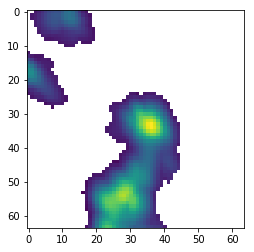

In [16]:
peak_intensity_sigmask = masked_cube.max(axis=0)

peak_intensity_sigmask.quicklook()

Here we see the 3 separate regions that we found to most likely be real signal in our data. Note especially that the regions with high noise towards the north-east were removed.

We can also examine the effect of the signal masking on individual spectra. The spectrum data with the mask applied can be accessed with `spectrum.filled_data[:]`, which will return an `astropy.Quantity` with appropriate brightness units (in this case, `K`).

As an example, we can compare the centre pixel at `(32, 32)` with and without the signal mask applied:

Text(0,0.5,'Brightness Temp. (K)')

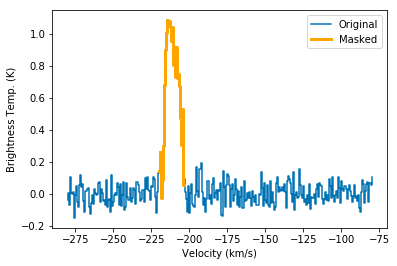

In [17]:
centre_spectrum = cube[:, 32, 32]
centre_spectrum_sigmask = masked_cube[:, 32, 32]

plt.plot(centre_spectrum.spectral_axis.value,
         centre_spectrum.filled_data[:].value,
         drawstyle='steps-mid', label='Original')
plt.plot(centre_spectrum_sigmask.spectral_axis.value,
         centre_spectrum_sigmask.filled_data[:].value, drawstyle='steps-mid',
         linewidth=3, label='Masked', color='orange')

plt.legend(frameon=True)

plt.xlabel("Velocity (km/s)")
plt.ylabel('Brightness Temp. (K)')

The signal mask appears to have successfully included most of the emission in the spectrum!

## Calculating moment maps ##

Now that we have identified signal in the cube, we will calculate common properties and highlight places where the signal masking has an enormous effect.

Moment maps can roughly be thought of as describing a single Gaussian-shaped spectrum. For example, the spectrum above is roughly a Gaussian, with some noise added. A model describing the signal in the spectrum is:
$$
S(v) = A \exp\left[-\frac{(v-v_0)^2}{2\sigma_v^2}\right],
$$
which includes the amplitude $A$, centroid velocity $v_0$, and line width $\sigma_v$.
And what we observe has some noise added, drawn from approximately a Gaussian _distribution_:
$$
T(v) = S(v) + \mathcal{N}(0, \sigma_{\textrm{noise}})
$$

The first 3 moment orders are the most commonly used. We will describe these in depth below.



### Integrated Intensity -- Moment 0 ###

The most common product is the integrated intensity, or the zeroth moment. This is defined as the integral of $S(v)$, or equivalently the sum over the signal in the observed spectrum:
$$
M_0 = \int_{\mathrm{line}} T(v)\,dv \approx \sum_{i\in\{\mathrm{line}\}} T(v_i)\,\delta v,
$$
where $\delta v$ is the channel width in the cube (in this case $0.67$ km/s).

The integrated intensity units in this case is K km/s.


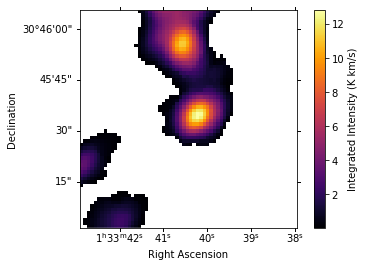

In [18]:
masked_moment0 = masked_cube.moment0()

ax = plt.subplot(projection=masked_moment0.wcs)
im = ax.imshow(masked_moment0.value, origin='lower', cmap='inferno')
cbar = plt.colorbar(im)
cbar.set_label('Integrated Intensity (K km/s)')

ax.set_ylabel('Declination')
ax.set_xlabel('Right Ascension')

The emission is dominated by the region in the centre. While the region is a single connected region, we see that there are two distinct sources: each is a giant molecular cloud (GMC).

Masking has less of an effect in this case because the noise values (on average) have a mean of 0. However, the masking will limit the uncertainty on the integrated intensity.


### Centroid Velocity -- Moment 1 ###

The first moment is the intensity-weighted average along the spectrum, or the centroid velocity:

$$
M_1 = \frac{\int_{\mathrm{line}} v T(v)\,dv}{\int_{\mathrm{line}} T(v)\,dv} \approx \frac{\sum_{i\in\{\mathrm{line}\}} v_i T(v_i)\,\delta v}{M_0}.
$$ 

If the signal is a single Gaussian, this will be equivalent to $v_0$ in the absence of noise.


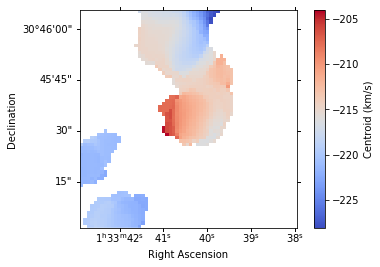

In [19]:
masked_moment1 = masked_cube.moment1()

ax = plt.subplot(projection=masked_moment1.wcs)
im = ax.imshow(masked_moment1.value, origin='lower', cmap='coolwarm')
cbar = plt.colorbar(im)
cbar.set_label('Centroid (km/s)')

ax.set_ylabel('Declination')
ax.set_xlabel('Right Ascension')

We see that the two regions towards the bottom of the image are more blue-shifted than the region in the centre. The region in the centre, containing 2 GMCs (see above) both appear to have mild velocity gradients.

With increasing order of moments, masking becomes more important as noise has a larger effect. Below is the centroid map _without_ the signal mask applied:

In [ ]:
unmasked_moment1 = cube.moment1()

ax = plt.subplot(projection=unmasked_moment1.wcs)
im = ax.imshow(unmasked_moment1.value, origin='lower', cmap='coolwarm')
cbar = plt.colorbar(im)
cbar.set_label('Centroid (km/s)')

ax.set_ylabel('Declination')
ax.set_xlabel('Right Ascension')

Spectra dominated by noise lead to extremely large outliers!

### Line width -- (Square root) Moment 2 ###

The second moment measure the [_variance_]((https://en.wikipedia.org/wiki/Variance)) of the spectrum around the centroid $v_0$, weighted by the intensity:
$$
M_2 = \frac{\int_{\mathrm{line}} (v-v_0)^2 T(v)\,dv}{\int_{\mathrm{line}} T(v)\,dv} \approx \frac{\sum_{i\in\{\mathrm{line}\}} (v_i-M_1)^2 T(v_i)\,\delta v}{M_0}.
$$ 


For a Gaussian spectrum, $M_2\approx\sigma_v^2$, and would be exact without noise.

While the moment 2 is often referenced as the line width, the line width is formally the square root of the second moment:
$$
\sigma_c \approx \sqrt{M_2}.
$$

In spectral-cube, these two quantities are labeled separately to avoid confusion. The second moment can be calculated with:

In [ ]:
masked_moment2 = masked_cube.moment2()

As the warning message explains, the _line width_ can be calculated with:

In [ ]:
masked_linewidth = masked_cube.linewidth_sigma()

ax = plt.subplot(projection=masked_linewidth.wcs)
im = ax.imshow(masked_linewidth.value, origin='lower', cmap='coolwarm')
cbar = plt.colorbar(im)
cbar.set_label('Line Width (km/s)')

ax.set_ylabel('Declination')
ax.set_xlabel('Right Ascension')

We see that the brightest regions in the integrated intensity map corresponds to the largest line widths. However, we note that the edges of the mask likely contain fewer spectral channels, which can artificially produce narrower line widths. Caution should be used when interpreting the line width where $\sim4$ or fewer channels are included in the mask.

Another common convention is to define the full-width-half-max line width:
$$
\textrm{FWHM}=\sigma_v \, \sqrt{8 \, {\rm ln} (2)} \ \approx 2.35 \sigma_v
$$

In spectral-cube, this can be calculated with:

In [ ]:
masked_fwhm = masked_cube.linewidth_fwhm()

As with the centroid, the line width derived from the second moment is very susceptible to noise. For example, without including the signal mask, the line width map would be:

In [ ]:
unmasked_linewidth = cube.linewidth_sigma()

ax = plt.subplot(projection=unmasked_linewidth.wcs)
im = ax.imshow(unmasked_linewidth.value, origin='lower', cmap='coolwarm')
cbar = plt.colorbar(im)
cbar.set_label('Line Width (km/s)')

ax.set_ylabel('Declination')
ax.set_xlabel('Right Ascension')

This is massively different from the masked version we have above. There are two key differences:

1. As with the centroid, there are many more outliers due to the noise.
2. Because $M_0$ is in the denominator, when it is negative due to noise, the "variance" becomes negative. When we take the square root to calculate the line width, the square root of a negative number becomes a `NaN`, hence the empty regions we see here.

Line widths are very susceptible to the noise. Estimates from the second moment are best used with a well-defined signal mask and high signal-to-noise ratios in the data.

### Higher-order moments ###

Occasionally higher order moments are used, however, these typically require very high signal-to-noise spectra because each successively higher order moment becomes more susceptible to noise.

The general form for the Nth moment is:
$$
M_n = \frac{\int_{\mathrm{line}} (v-v_0)^n T(v)\,dv}{\int_{\mathrm{line}} T(v)\,dv} \approx \frac{\sum_{i\in\{\mathrm{line}\}} (v_i-M_1)^n T(v_i)\,\delta v}{M_0}
$$

$M_3$ is related to the [_skewness_](https://en.wikipedia.org/wiki/Skewness), which measures the asymmetry of the spectrum centered at $v_0$. $M_4$ is related to the [_kurtosis_](https://en.wikipedia.org/wiki/Kurtosis), which measures if the tails of the spectrum are stronger or weaker than a Gaussian.

The Nth order moment can be computed with spectral-cube as:

In [ ]:
n = 3

nth_moment = masked_cube.moment(order=n)

ax = plt.subplot(projection=nth_moment.wcs)
im = ax.imshow(nth_moment.value, origin='lower', cmap='coolwarm')
cbar = plt.colorbar(im)
cbar.set_label(f'Order {n} Moment (km/s)^{n}')

ax.set_ylabel('Declination')
ax.set_xlabel('Right Ascension')

This example data set is not suited to explore higher-order moments and this above is only a demonstration of how to compute these moments.

### Spectra that are not single Gaussians ###

Moment calculations are often used because they are simple and quick to compute. However, when spectra are not well-modelled by a single Gaussian, the relation to the Gaussian parameters and what is measured from the spectrum breaks down. However, they can often remain useful as average of properties of the spectrum. If the analysis requires a more precise estimate of these properties, a Gaussian or multi-Gaussian model fit may be appropriate instead. See the [spectral-cube fitting tutorial](https://mybinder.org/v2/gh/radio-astro-tools/tutorials/spectral-fitting?filepath=spectral_fitting%2Ffitting_with_spectralcube.ipynb) for examples.

### Other common and useful properties ###

Two other properties are often computed and used. We have already used one---the peak intensity---above. For completness, the peak intensity is defined as:
$$
T_{\mathrm{max}} = \mathrm{max}_{i\in\{\mathrm{line}\}} T(v_i),
$$

This is simply the maximum over the spectral dimension.

In [ ]:
masked_tpeak = masked_cube.max(axis=0)

ax = plt.subplot(projection=masked_tpeak.wcs)
ax = plt.subplot()
im = ax.imshow(masked_tpeak.value, origin='lower', cmap='coolwarm')
cbar = plt.colorbar(im)
cbar.set_label('Peak Temperature (K)')

ax.set_ylabel('Declination')
ax.set_xlabel('Right Ascension')

For absorption lines, `min` may be more useful instead.

Lastly, the velocity at peak intensity is another commonly used property. This is defined simply as:
$$
v_{\mathrm{max}} = \mathrm{argmax}_{i\in\{\mathrm{line}\}} T(v_i),
$$
Again, in the case of a Gaussian spectrum, $v_{\mathrm{max}}=v_0$ in the absence of noise.

In spectral-cube, this can be calculated with:

In [ ]:
masked_peakvelocity = masked_cube.argmax_world(axis=0)

ax = plt.subplot(projection=masked_peakvelocity.wcs)
ax = plt.subplot()
im = ax.imshow(masked_peakvelocity.value, origin='lower', cmap='coolwarm')
cbar = plt.colorbar(im)
cbar.set_label('Velocity at peak temperature (km/s)')

ax.set_ylabel('Declination')
ax.set_xlabel('Right Ascension')

This is similar to the centroid map $M_1$, but appears "blockier" because of the discrete steps between spectral channels. The range of velocities are quite similar, however.